In [1]:
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, KFold
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
sys.path.append('..')
from tlfair.metrics import *
from tlfair.superlearner import *

In [22]:
def perm_importance(
    xtr,
    xte, 
    ytr,
    yte,
    gtr, 
    gte,
    metric,
    outcome,
    propensity,
    n_samples = 10,
    rng = None
    ):
    if rng is None:
        rng = np.random.default_rng()

    seq = xtr.columns
    seen = set()
    perms = []
    while len(perms) < n_samples:
        perm = tuple(rng.choice(seq, size=len(seq), replace=False))
        if perm not in seen:
            perms.append(perm)
            seen.add(perm)

    values = []
    importance = {}
    for col in seq:
        importance[col] = 0

    for perm in perms:
        prev = 0
        v = []
        for i in range(len(perm)):
            htr = xtr[list(perm[:i+1])]
            hte = xte[list(perm[:i+1])]
            res = metric(
                xtr = htr,
                xte = hte,
                ytr = ytr,
                yte = yte,
                gtr = gtr,
                gte = gte,
                outcome = outcome,
                propensity = propensity
                )
            est = res[0]
            importance[perm[i]] += (est-prev) / n_samples
            prev = est
            v.append(est)
        values.append(v)
    
    return importance, values, perms

def parity(
    xtr,
    xte, 
    ytr, 
    yte,
    gtr,
    gte,
    outcome,
    propensity=None):

    outcome = outcome.fit(xtr, ytr)
    phi0 = -1/np.mean(gte==0) * outcome.predict(xte.iloc[np.where(gte==0)[0],:])
    phi1 = 1/np.mean(gte==1) * outcome.predict(xte.iloc[np.where(gte==1)[0],:])
    phi = np.hstack([phi0, phi1])
    est = np.mean(phi)
    eif = phi - np.mean(phi)
    ci = (est - 1.96*np.sqrt(np.var(eif)/len(eif)), est + 1.96*np.sqrt(np.var(eif)/len(eif)))
    return est, ci

def prob_parity(
    xtr,
    xte, 
    ytr, 
    yte,
    gtr,
    gte,
    outcome,
    propensity=None):
    
    outcome = outcome.fit(xtr, ytr)
    propensity = propensity.fit(xtr,gtr)
    m_probs = propensity.predict_proba(xte)
    f_probs = outcome.predict_proba(xte)[:,1]
    phi0 = -1/(np.mean(gte==0)) * (m_probs[:,0]*((yte==1) -f_probs) + (gte==0)*f_probs)
    phi1 = 1/(np.mean(gte==1)) * (m_probs[:,1]*((yte==1) -f_probs) + (gte==1)*f_probs)
    phi = phi0 + phi1
    est = np.mean(phi)
    eif = phi - (np.mean(phi1) + np.mean(phi0))
    ci = (est - 1.96*np.sqrt(np.var(eif)/len(eif)), est + 1.96*np.sqrt(np.var(eif)/len(eif)))
    return est, ci

def cmi(
    xtr,
    xte, 
    ytr, 
    yte,
    gtr,
    gte,
    outcome,
    propensity=None):

    label = np.zeros(shape=(len(gtr),)).astype(np.int8)
    label[np.intersect1d(np.where(gtr==0), np.where(ytr==0))] = 0
    label[np.intersect1d(np.where(gtr==1), np.where(ytr==0))] = 1
    label[np.intersect1d(np.where(gtr==0), np.where(ytr==1))] = 2
    label[np.intersect1d(np.where(gtr==1), np.where(ytr==1))] = 3
    outcome = outcome.fit(xtr, label)

    est_vec = np.zeros(len(gte))
    lte = np.zeros(shape=(len(gte),)).astype(np.int8)
    lte[np.intersect1d(np.where(gte==0), np.where(yte==0))] = 0
    lte[np.intersect1d(np.where(gte==1), np.where(yte==0))] = 1
    lte[np.intersect1d(np.where(gte==0), np.where(yte==1))] = 2
    lte[np.intersect1d(np.where(gte==1), np.where(yte==1))] = 3
    tol = 1e-2
    preds = outcome.predict_proba(xte)
    for i in range(len(preds)):
        numerator = preds[i, lte[i]]
        if lte[i] == 0:
            denominator = (preds[i,0]+preds[i,2]) * (preds[i,0]+preds[i,1])
        elif lte[i] == 1:
            denominator = (preds[i,1]+preds[i,3]) * (preds[i,0]+preds[i,1])
        elif lte[i] == 2:
            denominator = (preds[i,0]+preds[i,2]) * (preds[i,2]+preds[i,3])
        elif lte[i] == 3:
            denominator = (preds[i,1]+preds[i,3]) * (preds[i,2]+preds[i,3])
        est_vec[i] = np.log((numerator)/(denominator))
    est = np.mean(est_vec)
    eif = (est_vec - est)
    ci = (est - 1.96*np.sqrt(np.var(eif)/len(eif)), est + 1.96*np.sqrt(np.var(eif)/len(eif)))
    return est, ci

In [18]:
law = pd.read_csv(
    "https://raw.githubusercontent.com/tailequy/fairness_dataset/refs/heads/main/experiments/data/law_school_clean.csv"
)

target = np.array(law[['pass_bar']]).ravel()
data = law.copy().drop(columns=['pass_bar'])
race_encoder = LabelEncoder().fit(data['race'])
data['race'] = race_encoder.transform(data['race'])

xtr, xte, ytr, yte = train_test_split(data, target, test_size=0.40, random_state=123)
gtr = np.array(xtr[['race']]).ravel()
gte = np.array(xte[['race']]).ravel()

xtr = xtr.drop(columns = ['race'])
xte = xte.drop(columns = ['race'])

<AxesSubplot:xlabel='decile1b', ylabel='zfygpa'>

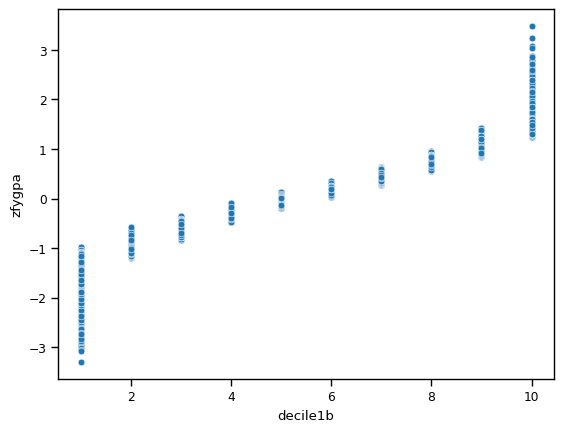

In [15]:
sns.scatterplot(xtr, x = 'decile1b', y='zfygpa')

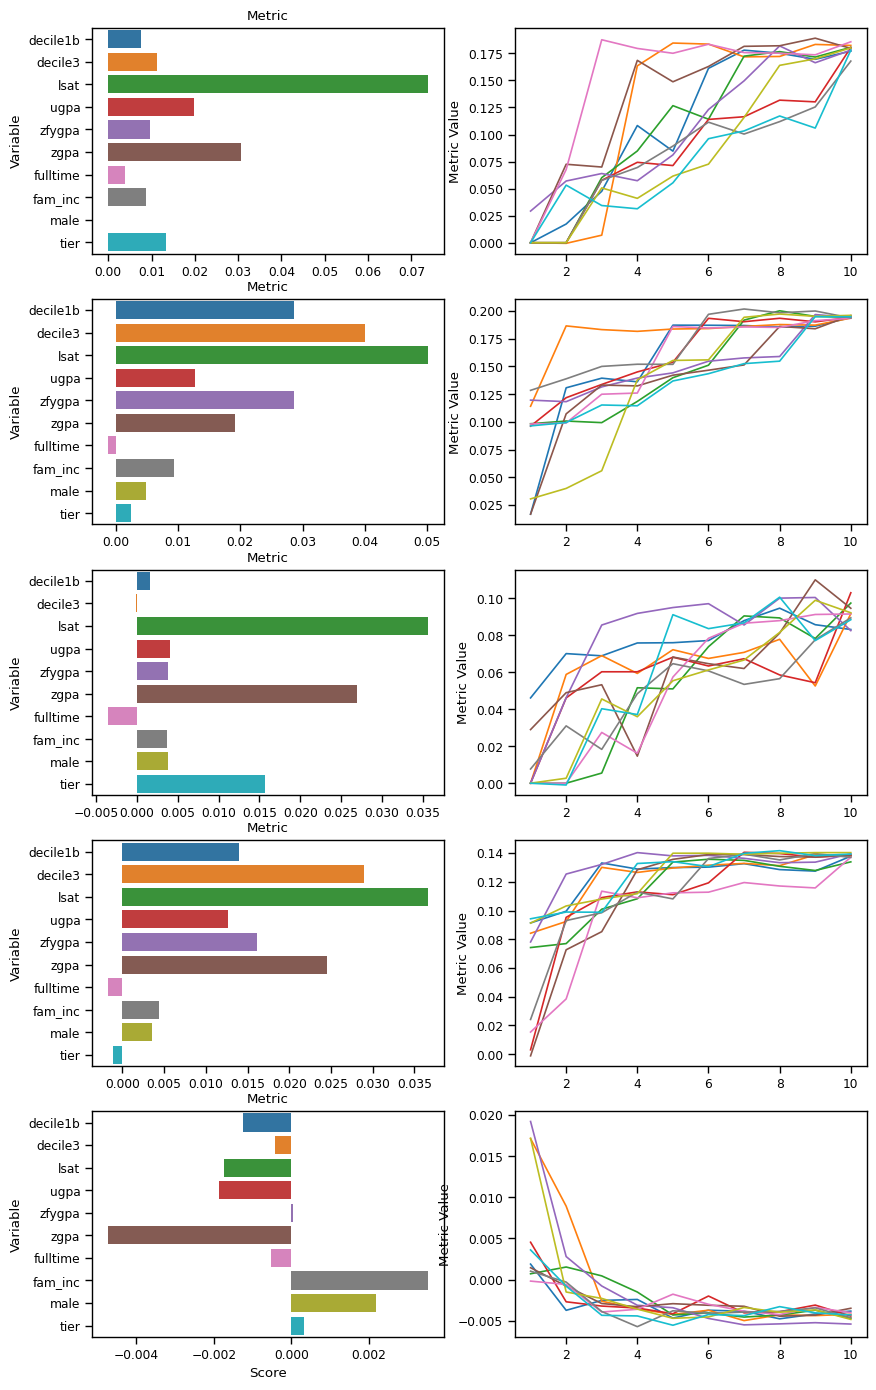

In [23]:
metrics = [
    parity,
    prob_parity,
    opportunity,
    prob_opportunity,
    cmi
]
fig, axs = plt.subplots(5, 2)
fig.set_figwidth(10)
fig.set_figheight(17)
sns.set_context('paper')
for i in range(len(metrics)):
    res = perm_importance(
        xtr = xtr,
        xte = xte,
        ytr = ytr,
        yte = yte,
        gtr = gtr,
        gte = gte,
        outcome = HistGradientBoostingClassifier(),
        propensity = HistGradientBoostingClassifier(),
        metric = metrics[i]
    )
    importance = res[0]
    importance_df = pd.DataFrame(
        {'Variable': list(importance.keys()),
        'Score': list(importance.values())}
    )
    sns.barplot(importance_df, y='Variable', x='Score', ax=axs[i,0])
    
    values = res[1]
    y = np.arange(1,len(xtr.columns)+1)
    for j in range(len(values)):
        axs[i,1].plot(y,values[j])

    axs[i,1].set_ylabel('Metric Value')
    if i < 4:
        axs[i,0].set_xlabel('')
        axs[i,1].set_xlabel('')
    axs[i,0].set_title('Metric')

In [24]:
metric_title = [
    'parity',
    'prob_parity',
    'opportunity',
    'prob_opp',
    'cmi'
    ]
for i in range(len(metrics)):
    metric = metrics[i]
    res = res = metric(
        xtr = xtr,
        xte = xte,
        ytr = ytr,
        yte = yte,
        gtr = gtr,
        gte = gte,
        outcome = HistGradientBoostingClassifier(),
        propensity = HistGradientBoostingClassifier(),
    )
    print(metric_title[i])
    print(res[0])
    print(res[1])

parity
0.17259698756594097
(0.11886461849369492, 0.226329356638187)
prob_parity
0.19495863965383986
(0.14630993333497333, 0.2436073459727064)
opportunity
0.09051593271589575
(0.01762646303127509, 0.16340540240051643)
prob_opp
0.1384297169583888
(0.07845544949304784, 0.19840398442372975)
cmi
-0.003885036797996486
(-0.006201322989802315, -0.001568750606190657)


In [25]:
metric_title = [
    'parity',
    'prob_parity',
    'opportunity',
    'prob_opp',
    'cmi'
    ]
for i in range(len(metrics)):
    metric = metrics[i]
    res = res = metric(
        xtr = xtr,
        xte = xte,
        ytr = ytr,
        yte = yte,
        gtr = gtr,
        gte = gte,
        outcome = SuperLearnerClassifier(),
        propensity = SuperLearnerClassifier(),
    )
    print(metric_title[i])
    print(res[0])
    print(res[1])

parity
0.18532137085364997
(0.13201115478693348, 0.23863158692036646)
prob_parity
0.19135354265960328
(0.1418791649757512, 0.24082792034345535)
opportunity
0.10615832365853471
(0.033997454311696, 0.1783191930053734)
prob_opp
0.12336749353518021
(0.0654956109141627, 0.18123937615619773)
cmi
0.01066904984233757
(0.006555440710365289, 0.014782658974309849)
